In [ ]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import cv2

# 데이터 로드 함수

def load_font_images(base_dir, target_size=(128, 128)):
    images = []
    labels = []
    font_dirs = sorted(os.listdir(base_dir))  # 폰트 디렉토리 정렬
    for font_label, font_dir in enumerate(font_dirs):
        font_path = os.path.join(base_dir, font_dir)
        if os.path.isdir(font_path):
            for file_name in sorted(os.listdir(font_path)):
                if file_name.endswith(".png"):
                    img_path = os.path.join(font_path, file_name)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, target_size).astype(np.float32) / 255.0  # 정규화
                        images.append(img)
                        labels.append(font_label)
    return np.array(images), np.array(labels)

def load_gothic_images(base_dir, target_size=(128, 128)):
    images = []
    for file_name in sorted(os.listdir(base_dir)):
        if file_name.endswith(".png"):
            img_path = os.path.join(base_dir, file_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, target_size).astype(np.float32) / 255.0  # 정규화
            images.append(img)
    return np.array(images)


input_path = "/Users/kimeunsur/2024winter/4주차/font_images/nanumgothic"
target_path = "/Users/kimeunsur/2024winter/4주차/font_images/font_dataset"

#X, font_labels = load_font_images(target_path)

# 데이터 로드
X_gothic = load_gothic_images(input_path)
Y_target, font_labels = load_font_images(target_path)

# 데이터 차원 추가 (128x128 -> 128x128x1)
X_gothic = np.expand_dims(X_gothic, axis=-1)
Y_target = np.expand_dims(Y_target, axis=-1)

# 폰트 레이블 원-핫 인코딩
num_styles = 22
font_one_hot = to_categorical(font_labels, num_classes=num_styles)

# 데이터 확인
print("X_gothic shape:", X_gothic.shape)  # (1400, 128, 128, 1)
print("Y_target shape:", Y_target.shape)  # (62392, 128, 128, 1)
print("Font labels shape:", font_one_hot.shape)  # (62392, 22)

X_gothic shape: (1400, 128, 128, 1)
Y_target shape: (62392, 128, 128, 1)
Font labels shape: (62392, 22)


In [2]:
# 고딕체 이미지를 타겟 데이터와 동일한 개수로 복제
num_target_samples = Y_target.shape[0]  # 22902
num_repeats = -(-num_target_samples // X_gothic.shape[0])  # 올림 계산
X_gothic_expanded = np.tile(X_gothic, (num_repeats, 1, 1, 1))  # 복제
X_gothic_expanded = X_gothic_expanded[:num_target_samples]  # 필요 개수만 자르기

# 데이터 확인
print("X_gothic_expanded shape:", X_gothic_expanded.shape)  # (62392, 128, 128, 1)
print("Y_target shape:", Y_target.shape)  # (62392, 128, 128, 1)
print("Font labels shape:", font_one_hot.shape)  # (62392, 22)

X_gothic_expanded shape: (62392, 128, 128, 1)
Y_target shape: (62392, 128, 128, 1)
Font labels shape: (62392, 22)


In [3]:
from sklearn.model_selection import train_test_split

# 학습/검증 데이터 분리
X_train, X_val, Y_train, Y_val, font_train, font_val = train_test_split(
    X_gothic_expanded, Y_target, font_one_hot, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)  # 학습 입력
print("X_val shape:", X_val.shape)      # 검증 입력
print("Y_train shape:", Y_train.shape)  # 학습 출력
print("Y_val shape:", Y_val.shape)      # 검증 출력
print("Font_train shape:", font_train.shape)  # 학습 폰트 정보
print("Font_val shape:", font_val.shape)      # 검증 폰트 정보

X_train shape: (49913, 128, 128, 1)
X_val shape: (12479, 128, 128, 1)
Y_train shape: (49913, 128, 128, 1)
Y_val shape: (12479, 128, 128, 1)
Font_train shape: (49913, 22)
Font_val shape: (12479, 22)


In [4]:
from tensorflow.keras import layers, Model

# 입력 정의
input_img = layers.Input(shape=(128, 128, 1), name="Input_Image")
font_input = layers.Input(shape=(22,), name="Font_Category")  # 타겟 스타일 정보

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)  # 256x256 -> 128x128

x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)  # 128x128 -> 64x64

encoded = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)

# Style Embedding
style_embedding = layers.Dense(128, activation="relu")(font_input)  # 줄어든 차원
style_embedding = layers.Reshape((1, 1, 128))(style_embedding)
style_embedding = layers.UpSampling2D((32, 32))(style_embedding)  # 1x1 -> 32x32

# Concatenate encoded image and style embedding
merged = layers.Concatenate()([encoded, style_embedding])

# Decoder
x = layers.Conv2DTranspose(128, (3, 3), activation="relu", padding="same")(merged)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)  # 32 -> 64

x = layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)  # 128x128 -> 256x256

decoded = layers.Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same")(x)

# 모델 정의
pre_training_model = Model(inputs=[input_img, font_input], outputs=decoded)

# 모델 컴파일
pre_training_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# 모델 구조 출력
pre_training_model.summary()

2025-01-20 14:02:19.800162: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-01-20 14:02:19.800196: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-01-20 14:02:19.800199: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-01-20 14:02:19.800422: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-20 14:02:19.800443: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Image         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ Input_Image[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Font_Category       │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      2,944 │ Font_Category[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 128) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ reshape[0][0]     │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_2[0][0],   │
│ (Concatenate)       │ 256)              │            │ up_sampling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    295,040 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │     73,792 │ up_sampling2d_1[… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 466,177 (1.78 MB)

 Trainable params: 465,601 (1.78 MB)

 Non-trainable params: 576 (2.25 KB)

In [6]:
nvidia-smi

NameError: name 'nvidia' is not defined

In [8]:
pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=fdac52460c54e4800cf4435aaf7eec87d26c88059f6978e938229fadcb933042
  Stored in directory: /Users/kimeunsur/Library/Caches/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built GPUtil
Note: you may need to restart the kernel to use updated packages.


In [9]:
import tensorflow as tf
from tensorflow.python.client import device_lib
import GPUtil

# 사용 가능한 GPU 정보 확인
print(device_lib.list_local_devices())

# GPU 상태 확인
gpus = GPUtil.getGPUs()
for gpu in gpus:
    print(f"GPU ID: {gpu.id}, Name: {gpu.name}")
    print(f"Load: {gpu.load * 100:.2f}%, Free Memory: {gpu.memoryFree}MB")
    print(f"Used Memory: {gpu.memoryUsed}MB, Total Memory: {gpu.memoryTotal}MB")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5396401859357896866
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 5143659760184763541
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]


2025-01-20 14:05:12.329688: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-20 14:05:12.329747: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
import tensorflow as tf

# 사용 가능한 GPU 확인
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
history = pre_training_model.fit(
    [X_train, font_train],  # 입력: 고딕체 이미지와 타겟 폰트 스타일
    Y_train,                # 출력: 타겟 폰트 스타일이 적용된 이미지
    validation_data=([X_val, font_val], Y_val),  # 검증 데이터
    epochs=50,
    batch_size=16,
)

Epoch 1/50


/Users/kimeunsur/yes/envs/newenv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Input_Image', 'Font_Category']. Received: the structure of inputs=('*', '*')
  warnings.warn(
2025-01-20 14:02:25.211117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


   6/3120 ━━━━━━━━━━━━━━━━━━━━ 42:11 813ms/step - loss: 0.2903 - mae: 0.4049

KeyboardInterrupt: 

In [ ]:
try:
    # 현재 모델 가중치 강제 저장
    pre_training_model.save_weights("model_checkpoint_force.h5")
    print("Model weights saved successfully!")
except Exception as e:
    print(f"Failed to save model weights: {e}")

In [ ]:
ps -e

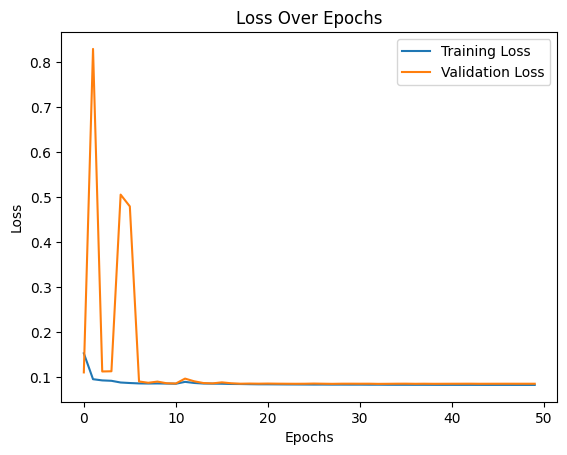

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

이제 전이학습일 시켜봅세다. transfer learning

In [20]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │        320 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 16, 16,    │     36,928 │ max_pooling2d_9[… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 32, 32,    │     18,464 │ up_sampling2d_4[… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_5     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 64, 64, 1) │        289 │ up_sampling2d_5[… │
│ (Conv2DTranspose)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 225,029 (879.02 KB)

 Trainable params: 74,881 (292.50 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 149,764 (585.02 KB)

In [57]:
from tensorflow.keras import layers, Model

encoder_input = model.input[0]
style_input = model.input[1]
encoded = model.get_layer("max_pooling2d_9").output  # 인코더 마지막 출력

# Style Embedding
style_embedding = layers.Dense(16 * 16 * 64, activation='relu')(style_input)
style_embedding = layers.Reshape((16, 16, 64))(style_embedding)

# Merge encoded and style embedding
merged = layers.Concatenate()([encoded, style_embedding])


x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(merged)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

# Fine-Tuning 모델 생성
fine_tuned_model = Model([encoder_input, style_input], decoded)
fine_tuned_model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [58]:
# 모델 입력 확인
print(fine_tuned_model.input)
# 모델 출력 확인
print(fine_tuned_model.output)

[<KerasTensor shape=(None, 64, 64, 1), dtype=float32, sparse=False, name=keras_tensor_46>, <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_47>]
<KerasTensor shape=(None, 64, 64, 1), dtype=float32, sparse=False, name=keras_tensor_127>


In [59]:
fine_tuned_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │        320 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 16384)     │     98,304 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 16, 16,    │          0 │ dense_15[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 16, 16,    │          0 │ max_pooling2d_9[… │
│ (Concatenate)       │ 128)              │            │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_30 │ (None, 16, 16,    │     73,792 │ concatenate_10[0… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_20    │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_31 │ (None, 32, 32,    │     18,464 │ up_sampling2d_20… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_21    │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_32 │ (None, 64, 64, 1) │        289 │ up_sampling2d_21… │
│ (Conv2DTranspose)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 210,049 (820.50 KB)

 Trainable params: 209,857 (819.75 KB)

 Non-trainable params: 192 (768.00 B)

In [60]:
import os
import cv2
import numpy as np

# 데이터 로드 함수
def load_handwritten_images(image_dir, target_size=(64, 64)):
    images = []
    labels = []
    file_names = sorted(os.listdir(image_dir))
    for file_name in file_names:
        if file_name.endswith(".jpg"):
            try:
                img_path = os.path.join(image_dir, file_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Warning: Unable to read {img_path}")
                    continue
                img = cv2.resize(img, target_size) / 255.0  # 픽셀 정규화
                images.append(img)
                label = os.path.splitext(file_name)[0]  # splittext 오타 수정
                labels.append(label)
            except Exception as e:
                print(f"Error processing file {file_name}: {e}")
    # NumPy 배열 변환 및 채널 차원 추가
    images_array = np.expand_dims(np.array(images), axis=-1)
    return images_array, labels

# 손글씨 데이터 경로
handwritten_path = "/Users/kimeunsur/2024winter/4주차/font_images/seungmin_hw"

# 손글씨 데이터 로드
X_handwritten, handwritten_labels = load_handwritten_images(handwritten_path)
style_label = 0
style_labels = np.full((len(X_handwritten),), style_label)
print(f"Handwritten data shape: {X_handwritten.shape}")
print(f"Number of labels: {len(handwritten_labels)}")


Handwritten data shape: (200, 64, 64, 1)
Number of labels: 200


In [61]:
# 원-핫 인코딩된 스타일 정보 생성 (단일 손글씨 스타일로 가정)
from tensorflow.keras.utils import to_categorical

style_label = 0  # 손글씨 스타일 번호
style_labels = np.full((len(X_handwritten),), style_label)
style_one_hot = to_categorical(style_labels, num_classes=1)  # 단일 클래스

# 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_val, style_train, style_val = train_test_split(X_handwritten, style_labels, test_size=0.2, random_state=42)

X_train, X_val, style_train, style_val = train_test_split(
    X_handwritten, style_labels, test_size=0.2, random_state=42
)

# 입력 데이터 형태 확인
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}")
print(f"style_train: {style_train.shape}, style_val: {style_val.shape}")


X_train: (160, 64, 64, 1), X_val: (40, 64, 64, 1)
style_train: (160,), style_val: (40,)


In [62]:
from tensorflow.keras.utils import to_categorical

# 스타일 레이블을 원-핫 인코딩
num_styles = 5  # 스타일 클래스 수
style_train_one_hot = to_categorical(style_train, num_classes=num_styles)
style_val_one_hot = to_categorical(style_val, num_classes=num_styles)

# 출력 확인
print("style_train_one_hot shape:", style_train_one_hot.shape)  # (160, 5)
print("style_val_one_hot shape:", style_val_one_hot.shape)      # (40, 5)

style_train_one_hot shape: (160, 5)
style_val_one_hot shape: (40, 5)


In [63]:
# 모델 학습
history = fine_tuned_model.fit(
    [X_train, style_train_one_hot],  # 입력: 이미지와 스타일
    X_train,                                 # 출력: 재구성된 이미지
    validation_data=([X_val, style_val_one_hot], X_val),
    epochs=50,
    batch_size=16
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step - loss: 0.1289 - mae: 0.2438 - val_loss: 0.0362 - val_mae: 0.0378
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0375 - mae: 0.0395 - val_loss: 0.0362 - val_mae: 0.0375
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0369 - mae: 0.0383 - val_loss: 0.0362 - val_mae: 0.0374
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0374 - mae: 0.0388 - val_loss: 0.0362 - val_mae: 0.0374
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - loss: 0.0374 - mae: 0.0387 - val_loss: 0.0362 - val_mae: 0.0374
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0371 - mae: 0.0385 - val_loss: 0.0362 - val_mae: 0.0374
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - loss: 0.0369 - mae: 0.0383 - val_loss: 0.0362 - val_mae: 0.0374
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - loss: 0.0374 - mae: 0.0387 - val_loss: 0.0362 - val_mae: 0.0374
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


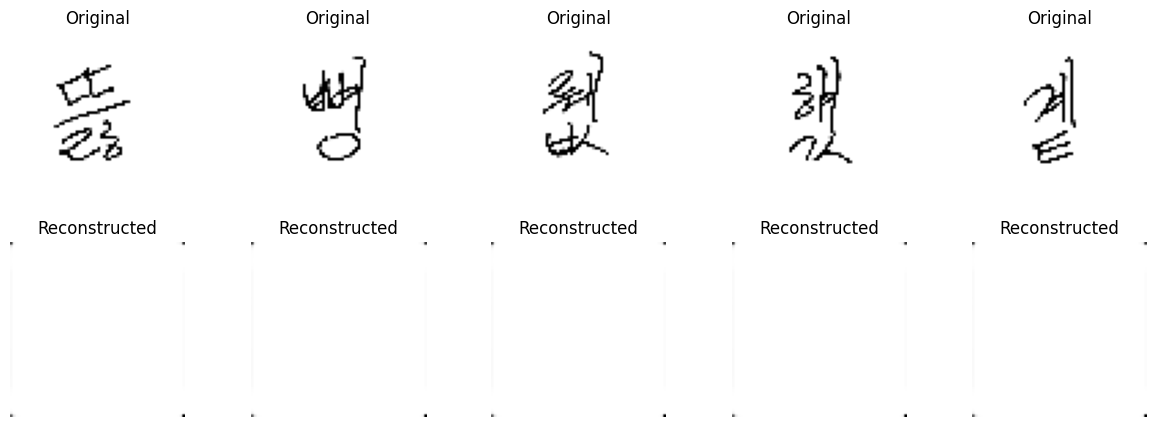

In [65]:
import matplotlib.pyplot as plt

# 검증 데이터에서 예측 결과 생성
reconstructed_images = fine_tuned_model.predict([X_val[:5], style_val_one_hot[:5]])

# 결과 시각화
n = 5  # 시각화할 샘플 수
plt.figure(figsize=(15, 5))
for i in range(n):
    # 원본 이미지
    plt.subplot(2, n, i + 1)
    plt.imshow(X_val[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    # 복원된 이미지
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()
